In [1]:
# stdlib imports
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 8")

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
from obspy.signal.invsim import corn_freq_2_paz, simulate_seismometer

# local imports
from amptools.io.read import read_data

%matplotlib inline

In [2]:
sac_file = '../tests/data/process/UW.BRKS..ENE.SAC'
result_file = '../tests/data/process/UW.BRKS..ENE.psa'
stream = read(sac_file)
trace = stream[0]
periods, sas = np.genfromtxt(result_file, unpack=True, usecols=(0, 1))

1.1400354830628163 1.136752 0.2884312292862117
2.249812327584463 2.229939 0.8872513731774074
1.928161149704601 1.927996 0.008565506964028162
1.8174568838485472 1.805717 0.648044185838359
1.3129304040257226 1.304918 0.6121365938074262
0.5698633573354558 0.565608 0.7495314272729147
0.10118492511600766 0.1001898 0.9883316939942597
0.050864411869311836 0.04986167 1.9910272507429758
0.020787275138224637 0.01976554 5.039034329636759


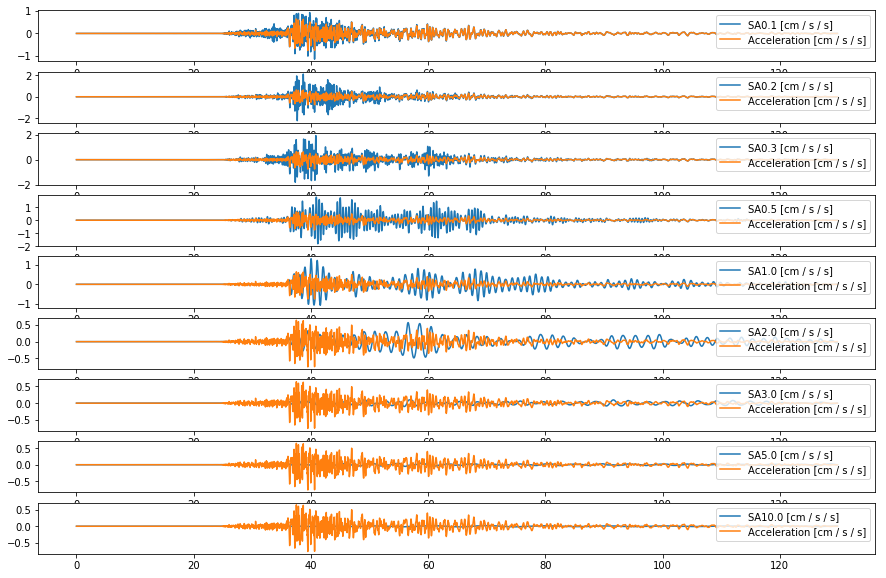

In [3]:
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 10))
damping = 0.05
dt = trace.stats.delta
for period, sa, ax in zip(periods, sas, axes):
    acc = trace.data
    npoints = len(acc)
    initialdisp = 0
    initialvel = 0
    damp = 0.05
    d = np.zeros(npoints)
    v = np.zeros(npoints)
    aa = np.zeros(npoints)

    d[0] = initialdisp
    v[0] = initialvel

    w = 2 * np.pi / period
    ww = w ** 2

    sqrtd  = np.sqrt(1 - damp**2)
    wd = w * sqrtd
    e = np.exp( - w * dt * damp)
    sine = np.sin(wd * dt)
    cosine = np.cos(wd * dt)
    aa[0] =  - ww * d[0] - (2. * damp * w) * v[0]

    a11 = e * ((damp / sqrtd) * sine + cosine)
    a12 = e * sine / wd
    cc = (e * (((1. - 2 * damp**2) / wd - (damp / sqrtd) * dt) * sine - ((2. * damp / w) + dt) * cosine) + (2. * damp / w)) * (-1. / (ww * dt))
    cd = (e * ( - (1. - 2 * damp**2) / wd * sine + (2. * damp / w) * cosine) + dt - (2. * damp / w)) * (-1. / (ww * dt))
    a21 =  - e * w * sine / sqrtd
    a22 = e * (cosine - (damp / sqrtd) * sine)
    ccp = (e * ((w * dt / sqrtd  + (damp / sqrtd)) * sine + cosine) - 1.) * (-1. / (ww * dt))
    cdp = (1. - a11) * (-1. / (ww * dt))

    for i in np.arange(1, npoints):
        d[i]  = a11 * d[i - 1]  +  \
                a12 * v[i - 1]  +  \
                cc * acc[i - 1]  +  \
                cd * acc[i]
        v[i]  = a21 * d[i - 1] + \
                a22 * v[i - 1] + \
                ccp * acc[i - 1] + \
                cdp * acc[i]
        aa[i] =  - ww * d[i] - (2. * damp * w) * v[i]

    ax.plot(trace.times(), aa, label='SA'  +  str(period)  +  ' [cm / s / s]')
    ax.plot(trace.times(), trace.data, label='Acceleration [cm / s / s]')
    maxy = np.max(np.abs(aa))
    print(maxy, sa, np.abs(maxy  -  sa) /  ((maxy  +  sa)  *  0.5)  *  100)
    legend = ax.legend()